In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from lightgbm import LGBMRegressor
from sklearn.metrics import mean_squared_error, r2_score
import warnings

warnings.filterwarnings('ignore')

# ---------------------------------------------------------
# Step 1. 데이터 로드
# ---------------------------------------------------------
df = pd.read_csv('crypto_lob_data.csv')
df['timestamp'] = pd.to_datetime(df['timestamp'])
df = df.sort_values('timestamp').reset_index(drop=True)

# ---------------------------------------------------------
# Step 2. Feature Engineering (퀀트 면접 핵심)
# ---------------------------------------------------------
# 1. Spread (호가 스프레드): 작을수록 유동성이 좋음
df['spread'] = df['ask_price'] - df['bid_price']

# 2. Mid Price (중간 가격)
df['mid_price'] = (df['ask_price'] + df['bid_price']) / 2

# 3. Order Imbalance (주문 불균형) - ★★★ 가장 중요한 변수
# 공식: Bid_Size / (Bid_Size + Ask_Size)
# 0.5보다 크면 매수 압력이 셈 -> 가격 상승 예측
df['imbalance'] = df['bid_size'] / (df['bid_size'] + df['ask_size'])

# 4. Past Returns (과거 모멘텀)
df['lag_return_1m'] = df['mid_price'].pct_change(60) # 1분 전 대비 수익률

# 결측치 제거 (lag 생성으로 인한 NaN)
df = df.dropna()

# ---------------------------------------------------------
# Step 3. Train / Val / Test Split (Manual Indexing)
# ---------------------------------------------------------
# 시계열이므로 섞지 않고 순서대로 자름 (60% / 20% / 20%)
n = len(df)
train_end = int(n * 0.6)
val_end = int(n * 0.8)

features = ['spread', 'imbalance', 'lag_return_1m', 'bid_size', 'ask_size', 'noise_1', 'noise_2']
target = 'target_return'

X = df[features]
y = df[target]

X_train = X.iloc[:train_end]
y_train = y.iloc[:train_end]

X_val = X.iloc[train_end:val_end]
y_val = y.iloc[train_end:val_end]

X_test = X.iloc[val_end:]
y_test = y.iloc[val_end:]

print(f"Data Split Completed. Train: {len(X_train)}, Val: {len(X_val)}, Test: {len(X_test)}")

# ---------------------------------------------------------
# Step 4. Modeling (LightGBM)
# ---------------------------------------------------------
model = LGBMRegressor(
    n_estimators=500,
    learning_rate=0.03,
    max_depth=5,
    num_leaves=20,
    random_state=42,
    n_jobs=-1,
    importance_type='gain' # 금융에선 gain(정보 획득량)이 split보다 더 유의미할 때가 많음
)

model.fit(
    X_train, y_train,
    eval_set=[(X_val, y_val)],
    eval_metric='rmse',
    callbacks=[
        lgb.early_stopping(stopping_rounds=30, verbose=True)
    ]
)

# ---------------------------------------------------------
# Step 5. Feature Selection & Evaluation
# ---------------------------------------------------------
# 1. Feature Importance 확인
imp_df = pd.DataFrame({
    'Feature': features,
    'Importance': model.feature_importances_
}).sort_values(by='Importance', ascending=False)

print("\n[Feature Importance]")
print(imp_df)

# 노이즈 변수(noise_1, 2)가 하위권인지 확인 -> 만약 상위권이면 과적합 의심
# Imbalance가 상위권이어야 정상

# 2. Test Set 예측
y_pred = model.predict(X_test)

# 평가
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
r2 = r2_score(y_test, y_pred) # 금융 데이터는 R2가 매우 낮음(0.01만 나와도 대박), 너무 실망 말 것

print(f"\nTest RMSE: {rmse:.4f}")
print(f"Test R2 Score: {r2:.4f}")

# ---------------------------------------------------------
# Step 6. 시각화 (인사이트 도출)
# ---------------------------------------------------------
# Imbalance와 실제 수익률 관계 (Imbalance가 높을 때 수익률도 높은지?)
plt.figure(figsize=(10, 6))
# 데이터가 많으니 100개만 샘플링해서 산점도
sample_idx = np.random.choice(X_test.index, 500, replace=False)
plt.scatter(df.loc[sample_idx, 'imbalance'], df.loc[sample_idx, 'target_return'], alpha=0.5)
plt.axhline(0, color='red', linestyle='--')
plt.axvline(0.5, color='red', linestyle='--')
plt.xlabel('Order Imbalance (Bid / Total)')
plt.ylabel('Future Return (bps)')
plt.title('Relationship: Order Imbalance vs Future Return')
plt.show()

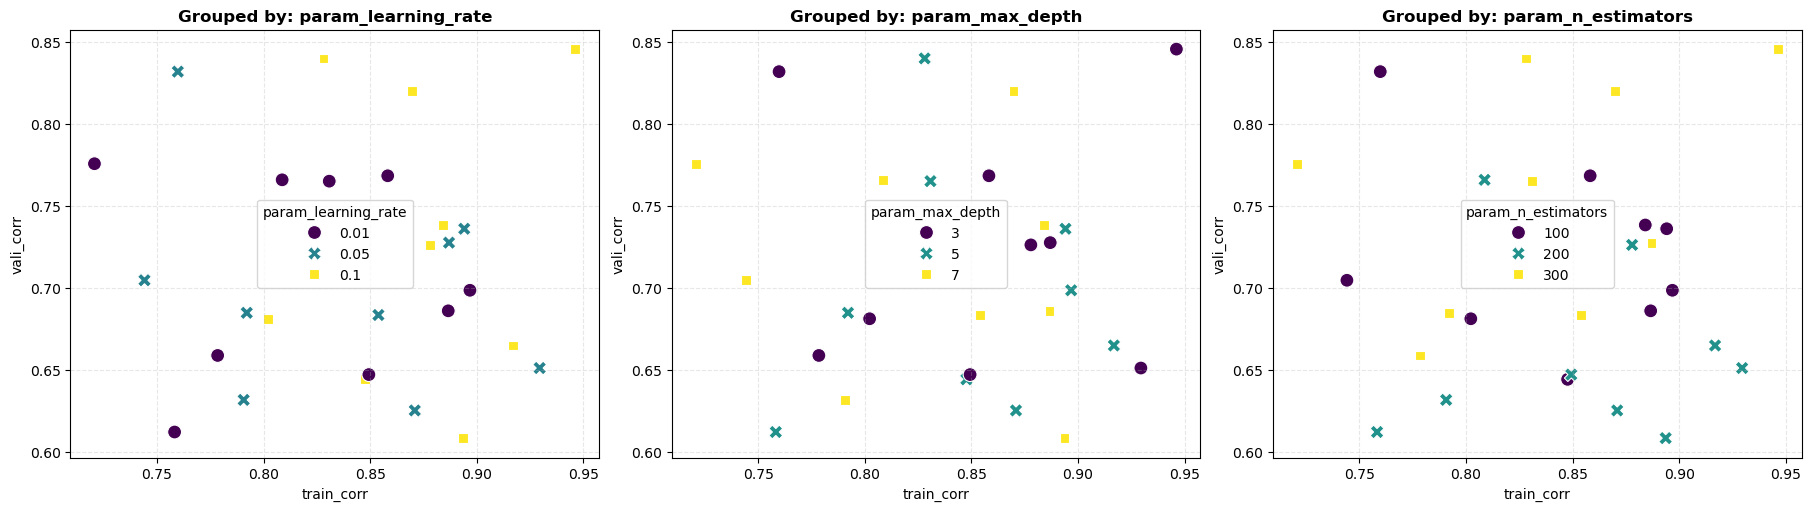

In [2]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np

# -------------------------------------------------------
# 1. 예시 데이터 생성 (GridSearchCV 결과라고 가정)
# -------------------------------------------------------
# 실제 사용하실 때는 df = pd.DataFrame(grid_search.cv_results_) 처럼 만드시면 됩니다.
data = {
    'param_learning_rate': [0.01, 0.01, 0.01, 0.05, 0.05, 0.05, 0.1, 0.1, 0.1] * 3,
    'param_max_depth': [3, 5, 7] * 9,
    'param_n_estimators': [100] * 9 + [200] * 9 + [300] * 9,
    # Train/Vali Corr (가상의 점수)
    'train_corr': np.random.uniform(0.7, 0.95, 27),
    'vali_corr': np.random.uniform(0.6, 0.85, 27)
}
df_results = pd.DataFrame(data)

# -------------------------------------------------------
# 2. 파라미터별 Scatter Subplot 그리기
# -------------------------------------------------------

def plot_grid_params(df, x_col='train_corr', y_col='vali_corr'):
    """
    df: Grid Search 결과 데이터프레임
    x_col: x축에 올 컬럼명 (Train Score)
    y_col: y축에 올 컬럼명 (Validation Score)
    """
    
    # 'param_'으로 시작하는 컬럼만 추출 (GridSearch 결과의 특징)
    # 만약 컬럼명이 다르다면 직접 리스트로 지정해도 됨: cols = ['alpha', 'beta']
    param_cols = [c for c in df.columns if c.startswith('param_')]
    n_params = len(param_cols)
    
    if n_params == 0:
        print("파라미터 컬럼(param_...)을 찾을 수 없습니다.")
        return

    # 서브플롯 생성 (파라미터 개수만큼 옆으로 나열)
    fig, axes = plt.subplots(1, n_params, figsize=(6 * n_params, 5), constrained_layout=True)
    
    # 파라미터가 1개일 경우 axes가 리스트가 아니므로 리스트로 감싸줌
    if n_params == 1:
        axes = [axes]

    for ax, col in zip(axes, param_cols):
        # Seaborn Scatterplot
        # hue: 색깔로 구분, style: 모양으로 구분
        sns.scatterplot(
            data=df, 
            x=x_col, 
            y=y_col, 
            hue=col, 
            style=col, 
            s=100,             # 점 크기
            palette='viridis', # 색상 팔레트 (취향껏 변경 가능: 'deep', 'Set2' 등)
            ax=ax
        )
        
        # 그래프 꾸미기
        ax.set_title(f'Grouped by: {col}', fontsize=12, fontweight='bold')
        ax.set_xlabel(x_col)
        ax.set_ylabel(y_col)
        ax.grid(True, alpha=0.3, linestyle='--')
        
        # 범례(Legend)가 너무 복잡하면 밖으로 빼거나 조정 가능
        # ax.legend(bbox_to_anchor=(1.05, 1), loc='upper left') 

    return fig

# 함수 실행 및 그래프 출력
fig = plot_grid_params(df_results, x_col='train_corr', y_col='vali_corr')
plt.show()